# Analysis of alloreactive T cell dataset

Analyzing data from [Fu et al. 2024](https://doi.org/10.1084/jem.20230930)

In [1]:
import os
import glob
import re
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from matplotlib import pyplot as plt
import seaborn as sns
import anndata as ad
import scanpy as sc
import scvelo as scv
from itertools import combinations
import warnings

In [2]:
# Create figure and output directories
DATA_DIR = "../data/fu"
FIG_DIR = "../figures/fu"
OUT_DIR = "../out/fu"
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

In [3]:
# Load the data
# Cell Ranger and velocyto: Need to make genes unique before merging
adatas_cr = {
    re.search("/cellranger/(.*)/outs", file).group(1): sc.read_10x_h5(file)
    for file in glob.glob(
        os.path.join(DATA_DIR, "cellranger/*/outs/filtered_feature_bc_matrix.h5")
    )
}
for adata in adatas_cr.values():
    adata.var_names_make_unique()
    
adatas_velo = {
    re.search("/cellranger/(.*)/velocyto", file).group(1): sc.read_loom(file)
    for file in glob.glob(os.path.join(DATA_DIR, "cellranger/*/velocyto/*.loom"))
}
for adata in adatas_velo.values():
    adata.var_names_make_unique()

adatas = {
    "reference": sc.read_h5ad(os.path.join(DATA_DIR, "reference/adata.h5ad")),
    "velocyto": ad.concat(
        adatas_velo, index_unique="_", label="sample"
    ),
    "alevin-fry": ad.concat(
        {
            re.search("/alevin/(.*)/quant_res", file).group(1): sc.read_h5ad(file)
            for file in glob.glob(os.path.join(DATA_DIR, "alevin/*/quant_res/adata.h5ad"))
        }, index_unique="_", label="sample"
    ),
    "tidesurf": ad.concat(
        {
            re.search("/tidesurf/(.*)/tidesurf.h5ad", file).group(1): sc.read_h5ad(file)
            for file in glob.glob(os.path.join(DATA_DIR, "tidesurf/*/tidesurf.h5ad"))
        }, index_unique="_", label="sample"
    ),
    "cellranger": ad.concat(
        adatas_cr, index_unique="_", label="sample"
    )
    
}

del adatas_cr
del adatas_velo

for method, adata in adatas.items():
    adata.var_names_make_unique()
    print(f"=====\n{method}\n")
    display(adata)
    print()

=====
reference



AnnData object with n_obs × n_vars = 51504 × 22684
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'pos', 'mt', 'clonotype', 'pre', 'post', 'pre_post', 'categories', 'nCount_SCT', 'nFeature_SCT', 'immune', 'L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9', 'L10', 'L11', 'L12', 'L13', 'L14', 'L15', 'L16', 'L17', 'L18', 'integrated_snn_res.0.5', 'seurat_clusters', 'integrated_snn_res.0.6', 'groups', 'repos', 'cate', 'cat', 'barcode', 'UMAP_1', 'UMAP_2'
    var: 'highly_variable'
    uns: 'groups_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'


=====
velocyto



AnnData object with n_obs × n_vars = 102316 × 36601
    obs: 'sample'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'


=====
alevin-fry



AnnData object with n_obs × n_vars = 110145 × 36601
    obs: 'barcodes', 'sample'
    layers: 'ambiguous', 'spliced', 'unspliced'


=====
tidesurf



AnnData object with n_obs × n_vars = 102316 × 14899
    obs: 'sample'
    layers: 'ambiguous', 'spliced', 'unspliced'


=====
cellranger



AnnData object with n_obs × n_vars = 102316 × 36601
    obs: 'sample'

In [4]:
# Change format of obs_names and get common cells
adatas["reference"].obs_names = adatas["reference"].obs_names.str.replace(
    "_\d+$", "_", regex=True
) + adatas["reference"].obs["orig.ident"].map(
    {
        "Pt15_POD1194": "MJ001",
        "Pt13_POD1032_IEL": "MJ002",
        "Pt13_POD1032_LPL": "MJ003",
        "Pt14_POD1764": "MJ005",
        "Pt21_POD626": "MJ006",
        "D251": "MJ007",
        "Pt04_POD1606_IEL": "MJ008",
        "Pt04_POD1606_LPL": "MJ009",
        "Pt16_POD1004_IEL": "MJ016",
        "Pt16_POD1004_LPL": "MJ017",
        "Pt21_POD1145_IEL": "MJ018",
        "Pt21_POD1145_LPL": "MJ019"}
).astype(str)
adatas["reference"].obs.drop(columns="barcode", inplace=True)
adatas["velocyto"].obs_names = adatas["velocyto"].obs_names.str.replace(
    "^.*:", "", regex=True
).str.replace("x_", "-1_", regex=True)
adatas["alevin-fry"].obs_names = adatas["alevin-fry"].obs_names.str.replace("_", "-1_")
adatas["alevin-fry"].obs.drop(columns="barcodes", inplace=True)
common_cells = pd.Index(
    set.intersection(
        *[set(adata.obs_names) for adata in adatas.values()]
    )
)
print(len(common_cells))

50448


In [5]:
# Get common genes
common_genes = pd.Index(
    set.intersection(
        *[set(adata.var_names) for adata in adatas.values()]
    )
)
print(len(common_genes))

14411


In [6]:
# Subset to common cells
adatas_sub = {
    method: adata[common_cells, :]
    for method, adata in adatas.items()
}

In [7]:
# Subset to common genes
adatas_common = {
    method: adata[:, common_genes]
    for method, adata in adatas_sub.items()
}

## Initial analysis: Counts

Comparison of methods w.r.t. total counts as well as spliced/ambiguous/unspliced counts per cell.

In [8]:
# Total counts per cell and count difference
total_counts = pd.concat(
    [
        pd.DataFrame(
            data=dict(
                {
                    method: np.asarray(
                        adata.layers["spliced"].sum(axis=1) +
                        adata.layers["unspliced"].sum(axis=1) +
                        adata.layers["ambiguous"].sum(axis=1)
                    ).flatten()
                    if method == "velocyto"
                    else np.asarray(adata.X.sum(axis=1)).flatten()
                    for method, adata in adatas_sub.items()
                    if method != "reference"
                }, genes="all"
            )
        ),
        pd.DataFrame(
            data=dict(
                {
                    method: np.asarray(
                        adata.layers["spliced"].sum(axis=1) +
                        adata.layers["unspliced"].sum(axis=1) +
                        adata.layers["ambiguous"].sum(axis=1)
                    ).flatten()
                    if method == "velocyto"
                    else np.asarray(adata.X.sum(axis=1)).flatten()
                    for method, adata in adatas_common.items()
                    if method != "reference"
                }, genes="common"
            )
        ),
    ]
)

counts_diff = pd.DataFrame(
    data={
        "velocyto": total_counts["cellranger"] - total_counts["velocyto"],
        "alevin-fry": total_counts["cellranger"] - total_counts["alevin-fry"],
        "tidesurf": total_counts["cellranger"] - total_counts["tidesurf"],
        "genes": total_counts["genes"]
    }
)

total_counts = total_counts.melt(id_vars="genes", var_name="method", value_name="counts")
total_counts.to_parquet(
    os.path.join(
        OUT_DIR, "total_counts.parquet.gz"
    ), compression="gzip"
)
counts_diff = counts_diff.melt(id_vars="genes", var_name="method", value_name="difference")
counts_diff.to_parquet(
    os.path.join(
        OUT_DIR, "counts_diff.parquet.gz"
    ), compression="gzip"
)

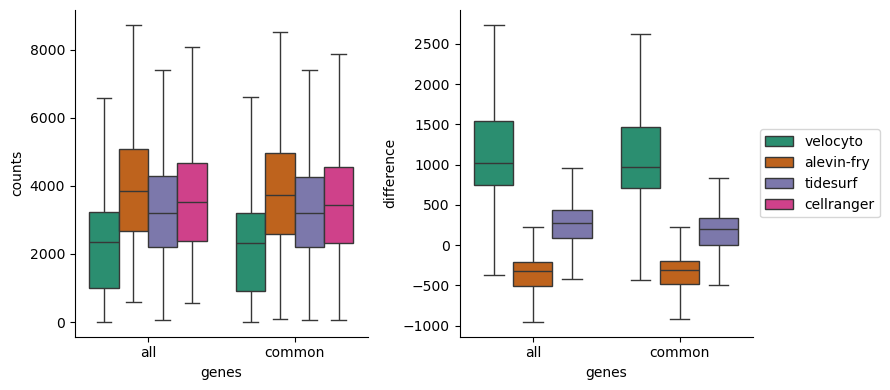

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

sns.boxplot(
    data=total_counts,
    x="genes",
    y="counts",
    hue="method",
    hue_order=[
        "velocyto", "alevin-fry", "tidesurf", "cellranger"
    ],
    palette="Dark2",
    showfliers=False,
    ax=axs[0]
)
axs[0].get_legend().remove()

sns.boxplot(
    data=counts_diff,
    x="genes",
    y="difference",
    hue="method",
    hue_order=[
        "velocyto", "alevin-fry", "tidesurf"
    ],
    palette="Dark2",
    showfliers=False,
    ax=axs[1]
)

handles, labels = axs[0].get_legend_handles_labels()
axs[1].legend(
    handles,
    labels,
    loc="center left",
    bbox_to_anchor=(1.0, 0.5)
)

sns.despine(fig)

fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR, "total_counts.png"), dpi=200)

In [10]:
# Spliced, unspliced, ambiguous per cell
spliced_unspliced_counts = pd.concat(
    [
        pd.DataFrame(
            data={
                "spliced": np.asarray(adata.layers["spliced"].sum(axis=1)).flatten(),
                "unspliced": np.asarray(adata.layers["unspliced"].sum(axis=1)).flatten(),
                "ambiguous": np.asarray(adata.layers["ambiguous"].sum(axis=1)).flatten(),
                "method": method,
                "genes": "all"
            }
        )
        for method, adata in adatas_sub.items()
        if method not in ["reference", "cellranger"]
    ] +
    [
        pd.DataFrame(
            data={
                "spliced": np.asarray(adata.layers["spliced"].sum(axis=1)).flatten(),
                "unspliced": np.asarray(adata.layers["unspliced"].sum(axis=1)).flatten(),
                "ambiguous": np.asarray(adata.layers["ambiguous"].sum(axis=1)).flatten(),
                "method": method,
                "genes": "common"
            }
        )
        for method, adata in adatas_common.items()
        if method not in ["reference", "cellranger"]
    ]
)

totals = (
    spliced_unspliced_counts["spliced"] +
    spliced_unspliced_counts["unspliced"] +
    spliced_unspliced_counts["ambiguous"]
)

spliced_unspliced_ratios = pd.DataFrame(
    data={
        "spliced": spliced_unspliced_counts["spliced"] / totals,
        "unspliced": spliced_unspliced_counts["unspliced"] / totals,
        "ambiguous": spliced_unspliced_counts["ambiguous"] / totals,
        "genes": spliced_unspliced_counts["genes"],
        "method": spliced_unspliced_counts["method"]
    }
)

spliced_unspliced_counts = spliced_unspliced_counts.melt(
    id_vars=["genes", "method"], var_name="splice_state", value_name="counts"
)
spliced_unspliced_counts.to_parquet(
    os.path.join(
        OUT_DIR, "spliced_unspliced_counts.parquet.gz"
    ), compression="gzip"
)
spliced_unspliced_ratios = spliced_unspliced_ratios.melt(
    id_vars=["genes", "method"], var_name="splice_state", value_name="ratio"
)
spliced_unspliced_ratios.to_parquet(
    os.path.join(
        OUT_DIR, "spliced_unspliced_ratios.parquet.gz"
    ), compression="gzip"
)

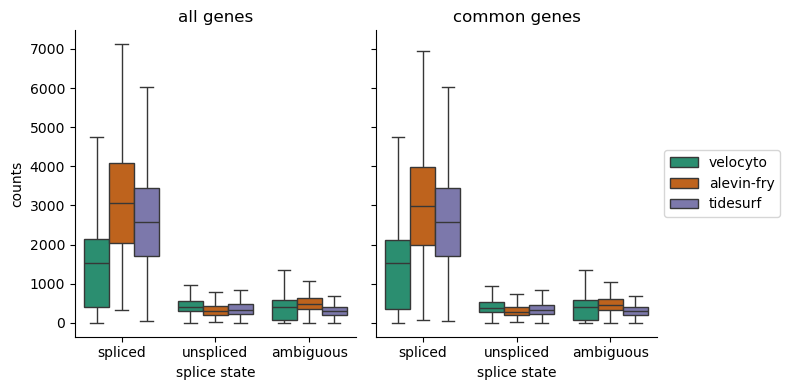

In [11]:
# Boxplots of spliced/unspliced/ambiguous counts
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey="row", sharex=True)

for i, subset in enumerate(["all", "common"]):
    sns.boxplot(
        data=spliced_unspliced_counts[spliced_unspliced_counts["genes"] == subset],
        x="splice_state",
        y="counts",
        hue="method",
        palette="Dark2",
        showfliers=False,
        ax=axs[i]
    )
    axs[i].set_title(f"{subset} genes")
    axs[i].set_xlabel("splice state")
    axs[i].get_legend().remove()

axs[1].legend(loc="center left", bbox_to_anchor=(1.0, 0.5))

sns.despine(fig)
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR, "spliced_unspliced_counts.png"), dpi=200)

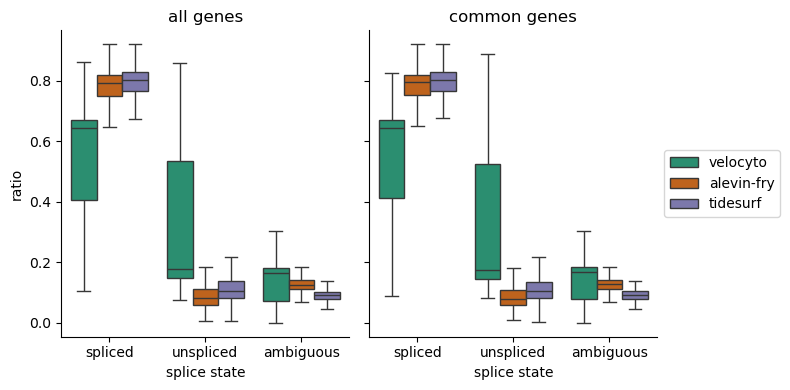

In [12]:
# Boxplots of spliced/unspliced/ambiguous ratios
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey="row", sharex=True)

for i, subset in enumerate(["all", "common"]):
    sns.boxplot(
        data=spliced_unspliced_ratios[spliced_unspliced_ratios["genes"] == subset],
        x="splice_state",
        y="ratio",
        hue="method",
        palette="Dark2",
        showfliers=False,
        ax=axs[i]
    )
    axs[i].set_title(f"{subset} genes")
    axs[i].get_legend().remove()
    axs[i].set_xlabel("splice state")

axs[1].legend(loc="center left", bbox_to_anchor=(1.0, 0.5))

sns.despine(fig)
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR, "spliced_unspliced_ratios.png"), dpi=200)

In [13]:
spliced_unspliced_ratios[
    spliced_unspliced_ratios["genes"] == "common"
].groupby(["method", "splice_state"]).mean(numeric_only=True)

ratio
method     splice_state          
alevin-fry ambiguous     0.128121
           spliced       0.780458
           unspliced     0.091421
tidesurf   ambiguous     0.092287
           spliced       0.789535
           unspliced     0.118178
velocyto   ambiguous     0.143315
           spliced       0.563313
           unspliced     0.293372

In [14]:
spliced_unspliced_sums_ts_all = pd.DataFrame(
    data={
        "spliced": np.asarray(adatas_sub["tidesurf"].layers["spliced"].sum(axis=1)).flatten(),
        "unspliced": np.asarray(adatas_sub["tidesurf"].layers["unspliced"].sum(axis=1)).flatten(),
        "ambiguous": np.asarray(adatas_sub["tidesurf"].layers["ambiguous"].sum(axis=1)).flatten()
    }
)
spliced_unspliced_sums_ts_common = pd.DataFrame(
    data={
        "spliced": np.asarray(adatas_common["tidesurf"].layers["spliced"].sum(axis=1)).flatten(),
        "unspliced": np.asarray(adatas_common["tidesurf"].layers["unspliced"].sum(axis=1)).flatten(),
        "ambiguous": np.asarray(adatas_common["tidesurf"].layers["ambiguous"].sum(axis=1)).flatten()
    }
)

spliced_unspliced_diff = pd.concat(
    [
        pd.DataFrame(
            data={
                "spliced": (
                    np.asarray(adatas_sub[method].layers["spliced"].sum(axis=1)).flatten()
                    - spliced_unspliced_sums_ts_all["spliced"]
                ),
                "unspliced": (
                    np.asarray(adatas_sub[method].layers["unspliced"].sum(axis=1)).flatten()
                    - spliced_unspliced_sums_ts_all["unspliced"]
                ),
                "ambiguous": (
                    np.asarray(adatas_sub[method].layers["ambiguous"].sum(axis=1)).flatten()
                    - spliced_unspliced_sums_ts_all["ambiguous"]
                ),
                "genes": "all",
                "method": method
            }
        )
        for method in ["velocyto", "alevin-fry"]
    ] + 
    [
        pd.DataFrame(
            data={
                "spliced": (
                    np.asarray(adatas_common[method].layers["spliced"].sum(axis=1)).flatten()
                    - spliced_unspliced_sums_ts_all["spliced"]
                ),
                "unspliced": (
                    np.asarray(adatas_common[method].layers["unspliced"].sum(axis=1)).flatten()
                    - spliced_unspliced_sums_ts_all["unspliced"]
                ),
                "ambiguous": (
                    np.asarray(adatas_common[method].layers["ambiguous"].sum(axis=1)).flatten()
                    - spliced_unspliced_sums_ts_all["ambiguous"]
                ),
                "genes": "common",
                "method": method
            }
        )
        for method in ["velocyto", "alevin-fry"]
    ]
).melt(
    id_vars=["genes", "method"], var_name="splice_state", value_name="diff"
)
spliced_unspliced_diff.to_parquet(
    os.path.join(
        OUT_DIR, "spliced_unspliced_diff.parquet.gz"
    ), compression="gzip"
)

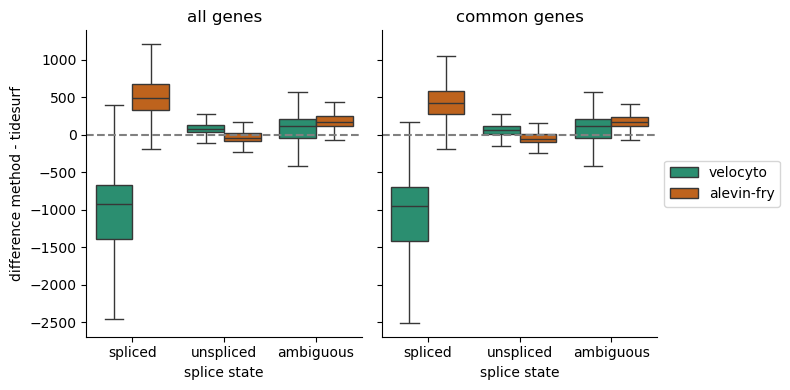

In [15]:
# Boxplots of spliced/unspliced/ambiguous counts
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey="row", sharex=True)

for i, subset in enumerate(["all", "common"]):
    sns.boxplot(
        data=spliced_unspliced_diff[spliced_unspliced_diff["genes"] == subset],
        x="splice_state",
        y="diff",
        hue="method",
        palette="Dark2",
        showfliers=False,
        ax=axs[i]
    )
    axs[i].set_title(f"{subset} genes")
    axs[i].set_xlabel("splice state")
    axs[i].set_ylabel("difference method - tidesurf")
    axs[i].get_legend().remove()
    axs[i].axhline(color="grey", linestyle="--")

axs[1].legend(loc="center left", bbox_to_anchor=(1.0, 0.5))

sns.despine(fig)
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR, "spliced_unspliced_diff.png"), dpi=200)

In [16]:
# Create dictionary for easier comparisons
comp_dict = {
    "tidesurf_velocyto": (adatas_common["tidesurf"], adatas_common["velocyto"]),
    "tidesurf_alevin-fry": (adatas_common["tidesurf"], adatas_common["alevin-fry"]),
    "velocyto_alevin-fry": (adatas_common["velocyto"], adatas_common["alevin-fry"])
}

In [17]:
# Pearson correlation of spliced/unspliced/ambiguous counts per gene
counts_corr = pd.concat(
    [
        pd.DataFrame(
            data={
                "comparison": comp,
                "spliced": stats.pearsonr(
                    adata_1.layers["spliced"].toarray(),
                    adata_2.layers["spliced"].toarray(),
                    axis=0
                )[0],
                "unspliced": stats.pearsonr(
                    adata_1.layers["unspliced"].toarray(),
                    adata_2.layers["unspliced"].toarray(),
                    axis=0
                )[0],
                "ambiguous": stats.pearsonr(
                    adata_1.layers["ambiguous"].toarray(),
                    adata_2.layers["ambiguous"].toarray(),
                    axis=0
                )[0],
            }
        )
        for comp, (adata_1, adata_2) in comp_dict.items()
    ]
).melt(
    id_vars="comparison", var_name="splice_state", value_name="pearsonr"
)
counts_corr.to_parquet(
    os.path.join(
        OUT_DIR, "spliced_unspliced_corr.parquet.gz"
    ), compression="gzip"
)

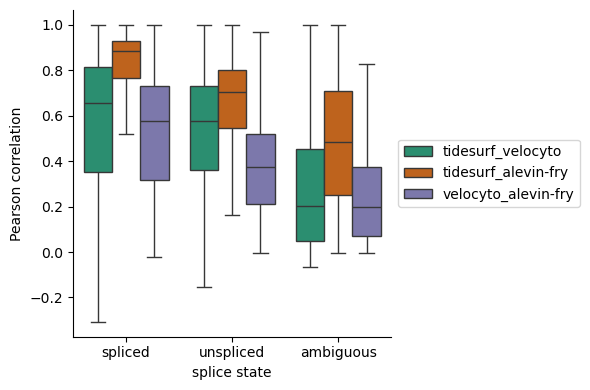

In [18]:
# Boxplots of correlations for spliced/unspliced/ambiguous counts
fig, ax = plt.subplots(figsize=(6, 4))

sns.boxplot(
    data=counts_corr,
    x="splice_state",
    y="pearsonr",
    hue="comparison",
    palette="Dark2",
    showfliers=False,
    ax=ax
)
ax.set_xlabel("splice state")
ax.set_ylabel("Pearson correlation")

ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))

sns.despine(fig)
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR, "spliced_unspliced_corr.png"), dpi=200)

In [19]:
# Cosine similarity of spliced/unspliced/ambiguous counts per cell
counts_cosine = pd.concat(
    [
        pd.DataFrame(
            data={
                "comparison": comp,
                "spliced": np.diagonal(
                    cosine_similarity(
                        adata_1.layers["spliced"].toarray(),
                        adata_2.layers["spliced"].toarray(),
                    )
                ),
                "unspliced": np.diagonal(
                    cosine_similarity(
                        adata_1.layers["unspliced"].toarray(),
                        adata_2.layers["unspliced"].toarray(),
                    )
                ),
                "ambiguous": np.diagonal(
                    cosine_similarity(
                        adata_1.layers["ambiguous"].toarray(),
                        adata_2.layers["ambiguous"].toarray(),
                    )
                ),
            }
        )
        for comp, (adata_1, adata_2) in comp_dict.items()
    ]
).melt(
    id_vars="comparison", var_name="splice_state", value_name="cosine_similarity"
)
counts_cosine.to_parquet(
    os.path.join(
        OUT_DIR, "spliced_unspliced_cosine.parquet.gz"
    ), compression="gzip"
)

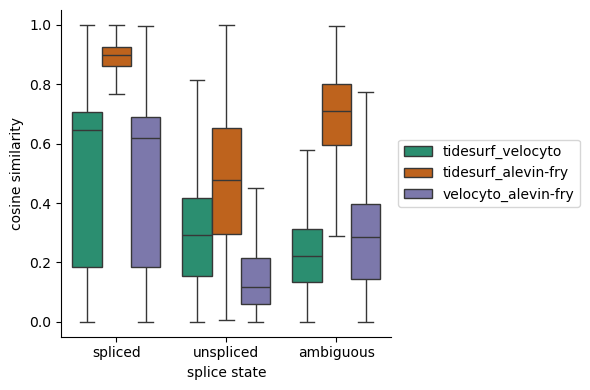

In [20]:
# Boxplots of cosine similarities for spliced/unspliced/ambiguous counts
fig, ax = plt.subplots(figsize=(6, 4))

sns.boxplot(
    data=counts_cosine,
    x="splice_state",
    y="cosine_similarity",
    hue="comparison",
    palette="Dark2",
    showfliers=False,
    ax=ax
)
ax.set_xlabel("splice state")
ax.set_ylabel("cosine similarity")

ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))

sns.despine(fig)
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR, "spliced_unspliced_cosine.png"), dpi=200)

In [21]:
# Euclidean distance of spliced/unspliced/ambiguous counts per cell
counts_euclidean = pd.concat(
    [
        pd.DataFrame(
            data={
                "comparison": comp,
                "spliced": np.diagonal(
                    euclidean_distances(
                        adata_1.layers["spliced"].toarray(),
                        adata_2.layers["spliced"].toarray(),
                    )
                ),
                "unspliced": np.diagonal(
                    euclidean_distances(
                        adata_1.layers["unspliced"].toarray(),
                        adata_2.layers["unspliced"].toarray(),
                    )
                ),
                "ambiguous": np.diagonal(
                    euclidean_distances(
                        adata_1.layers["ambiguous"].toarray(),
                        adata_2.layers["ambiguous"].toarray(),
                    )
                ),
            }
        )
        for comp, (adata_1, adata_2) in comp_dict.items()
    ]
).melt(
    id_vars="comparison", var_name="splice_state", value_name="euclidean_distance"
)
counts_euclidean.to_parquet(
    os.path.join(
        OUT_DIR, "spliced_unspliced_euclidean.parquet.gz"
    ), compression="gzip"
)

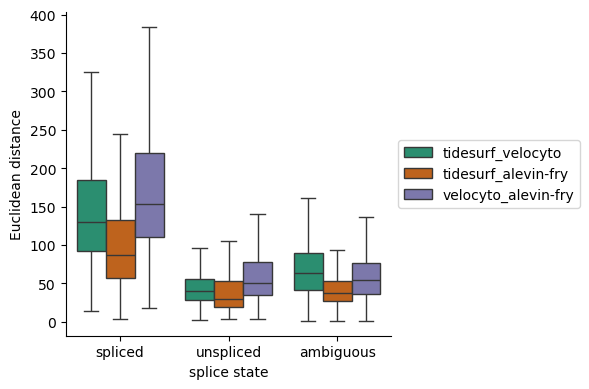

In [22]:
# Boxplots of Euclidean distances for spliced/unspliced/ambiguous counts
fig, ax = plt.subplots(figsize=(6, 4))

sns.boxplot(
    data=counts_euclidean,
    x="splice_state",
    y="euclidean_distance",
    hue="comparison",
    palette="Dark2",
    showfliers=False,
    ax=ax
)
ax.set_xlabel("splice state")
ax.set_ylabel("Euclidean distance")

ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))

sns.despine(fig)
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR, "spliced_unspliced_euclidean.png"), dpi=200)

In [23]:
# Pearson correlation with Cell Ranger per gene
counts_corr_cr = pd.concat(
    [
        pd.DataFrame(
            data={
                "method": method,
                "pearsonr": stats.pearsonr(
                    (
                        adata.layers["spliced"] +
                        adata.layers["unspliced"] +
                        adata.layers["ambiguous"]
                    ).toarray()
                    if method == "velocyto"
                    else adata.X.toarray(),
                    adatas_common["cellranger"].X.toarray(),
                    axis=0
                )[0]
            }
        )
        for method, adata in adatas_common.items()
        if method not in ["reference", "cellranger"]
    ]
).reset_index(drop=True)
counts_corr_cr.to_parquet(
    os.path.join(
        OUT_DIR, "counts_corr_cellranger.parquet.gz"
    ), compression="gzip"
)

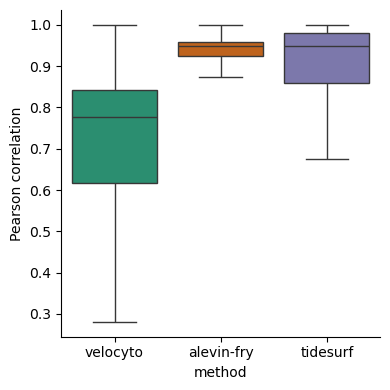

In [24]:
# Boxplots of correlations with Cell Ranger
fig, ax = plt.subplots(figsize=(4, 4))

sns.boxplot(
    data=counts_corr_cr,
    x="method",
    y="pearsonr",
    hue="method",
    palette="Dark2",
    showfliers=False,
    ax=ax
)
ax.set_ylabel("Pearson correlation")


sns.despine(fig)
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR, "counts_corr_cellranger.png"), dpi=200)

In [25]:
# Cosine similarity with Cell Ranger per cell
counts_cosine_cr = pd.concat(
    [
        pd.DataFrame(
            data={
                "method": method,
                "cosine_similarity": np.diagonal(
                    cosine_similarity(
                        (
                            adata.layers["spliced"] +
                            adata.layers["unspliced"] +
                            adata.layers["ambiguous"]
                        ).toarray()
                        if method == "velocyto"
                        else adata.X.toarray(),
                        adatas_common["cellranger"].X.toarray()
                    )
                )
            }
        )
        for method, adata in adatas_common.items()
        if method not in ["reference", "cellranger"]
    ]
).reset_index(drop=True)
counts_cosine_cr.to_parquet(
    os.path.join(
        OUT_DIR, "counts_cosine_cellranger.parquet.gz"
    ), compression="gzip"
)

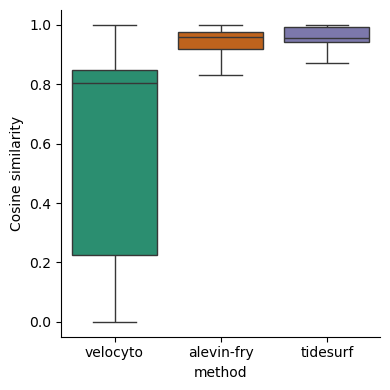

In [26]:
# Boxplots of cosine similarities with Cell Ranger
fig, ax = plt.subplots(figsize=(4, 4))

sns.boxplot(
    data=counts_cosine_cr,
    x="method",
    y="cosine_similarity",
    hue="method",
    palette="Dark2",
    showfliers=False,
    ax=ax
)
ax.set_ylabel("Cosine similarity")


sns.despine(fig)
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR, "counts_cosine_cellranger.png"), dpi=200)

In [27]:
# Euclidean distance from Cell Ranger per cell
counts_euclidean_cr = pd.concat(
    [
        pd.DataFrame(
            data={
                "method": method,
                "euclidean_distance": np.diagonal(
                    euclidean_distances(
                        (
                            adata.layers["spliced"] +
                            adata.layers["unspliced"] +
                            adata.layers["ambiguous"]
                        ).toarray()
                        if method == "velocyto"
                        else adata.X.toarray(),
                        adatas_common["cellranger"].X.toarray()
                    )
                )
            }
        )
        for method, adata in adatas_common.items()
        if method not in ["reference", "cellranger"]
    ]
).reset_index(drop=True)
counts_euclidean_cr.to_parquet(
    os.path.join(
        OUT_DIR, "counts_euclidean_cellranger.parquet.gz"
    ), compression="gzip"
)

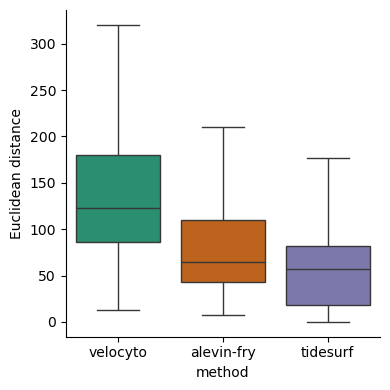

In [28]:
# Boxplots of Euclidean distances with Cell Ranger
fig, ax = plt.subplots(figsize=(4, 4))

sns.boxplot(
    data=counts_euclidean_cr,
    x="method",
    y="euclidean_distance",
    hue="method",
    palette="Dark2",
    showfliers=False,
    ax=ax
)
ax.set_ylabel("Euclidean distance")


sns.despine(fig)
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR, "counts_euclidean_cellranger.png"), dpi=200)

## Data processing

In [29]:
adatas_velocity = {
    method: adata.copy()
    for method, adata in adatas_common.items()
    if method not in ["reference", "cellranger"]
}

In [30]:
# # Add ambiguous counts to spliced (standard for alevin-fry)
# for method, adata in adatas_velocity.items():
#     if "ambiguous" in adata.layers:
#         adata.layers["spliced"] = adata.layers["spliced"] + adata.layers["ambiguous"]
#         del adata.layers["ambiguous"]

In [31]:
# Normalize data
for adata in adatas_velocity.values():
    scv.pp.filter_genes(
        adata,
        min_shared_counts=20
    )
    scv.pp.normalize_per_cell(adata)
    scv.pp.filter_genes_dispersion(
        adata, n_top_genes=2000, subset=False
    )
    sc.pp.log1p(adata)
    
    # Add annotations from reference dataset
    adata.obs["groups"] = adatas_common["reference"].obs["groups"].copy()
    adata.uns = adatas_common["reference"].uns.copy()
    adata.obsm = adatas_common["reference"].obsm.copy()

Filtered out 6364 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Filtered out 6328 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Filtered out 5767 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.


In [32]:
# Compute neighborhood graph for reference data
sc.pp.neighbors(adatas_common["reference"], n_pcs=30, n_neighbors=30)

# Transfer neighborhood graph to other datasets 
# and compute moments
for method, adata in adatas_velocity.items():
    adata.uns["neighbors"] = adatas_common["reference"].uns["neighbors"].copy()
    adata.obsp = adatas_common["reference"].obsp.copy()
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

computing moments based on connectivities
    finished (0:00:26) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing moments based on connectivities
    finished (0:00:31) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing moments based on connectivities
    finished (0:00:35) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [33]:
# Compute RNA velocity
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for adata in adatas_velocity.values():
        scv.tl.velocity(adata)
        scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:29) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/52 cores)


  0%|          | 0/50448 [00:00<?, ?cells/s]

    finished (0:00:43) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocities
    finished (0:01:03) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/52 cores)


  0%|          | 0/50448 [00:00<?, ?cells/s]

    finished (0:03:28) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocities
    finished (0:00:35) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/52 cores)


  0%|          | 0/50448 [00:00<?, ?cells/s]

    finished (0:02:34) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:10) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:11) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:12) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


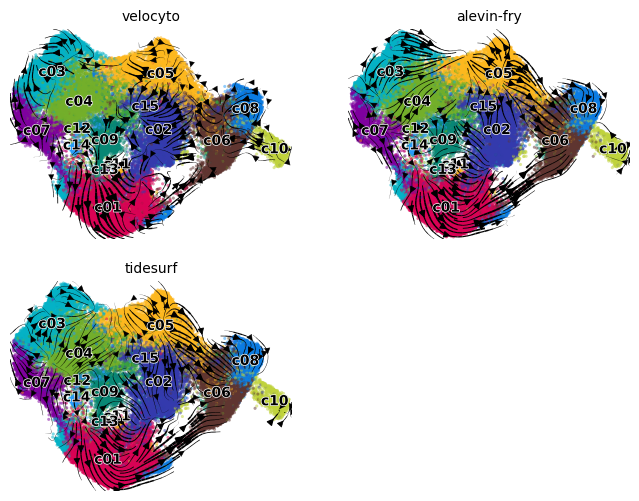

In [34]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fig, axs = plt.subplots(2, 2, figsize=(8, 6))

    for i, (method, adata) in enumerate(adatas_velocity.items()):
        scv.pl.velocity_embedding_stream(
            adata,
            basis="umap",
            color="groups",
            size=20,
            alpha=0.5,
            show=False,
            ax=axs.flat[i],
            title=method
        )
    axs.flat[-1].set_visible(False)
fig.savefig(os.path.join(FIG_DIR, "velocity_embedding_stream.png"), dpi=200)

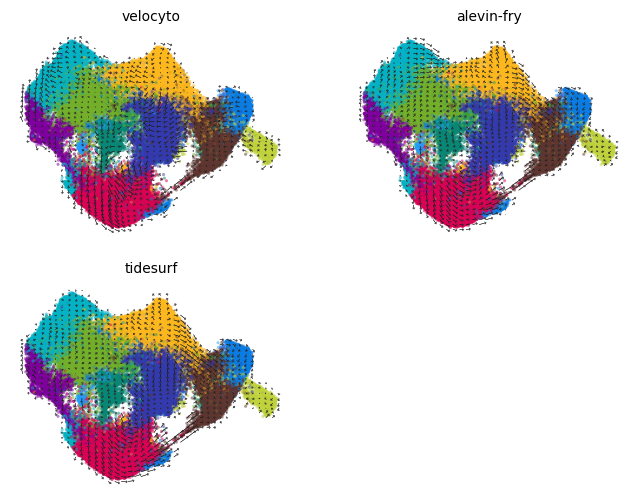

In [35]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fig, axs = plt.subplots(2, 2, figsize=(8, 6))

    for i, (method, adata) in enumerate(adatas_velocity.items()):
        scv.pl.velocity_embedding_grid(
            adata,
            basis="umap",
            color="groups",
            size=20,
            alpha=0.5,
            arrow_length=2,
            arrow_size=(10, 18, 8),
            density=0.8,
            show=False,
            ax=axs.flat[i],
            title=method
        )
    axs.flat[-1].set_visible(False)
fig.savefig(os.path.join(FIG_DIR, "velocity_embedding_grid.png"), dpi=200)

In [36]:
# Compute pairwise common genes
common_genes_velocities = {
    method_1 + "_" + method_2: pd.Index(
        set(adatas_velocity[method_1].var_names).intersection(
            set(adatas_velocity[method_2].var_names)
        )
    )
    for method_1, method_2 in combinations(adatas_velocity, 2)
}
for comp, genes in common_genes_velocities.items():
    print(f"{comp}: {len(genes)} common genes")

velocyto_alevin-fry: 7036 common genes
velocyto_tidesurf: 7478 common genes
alevin-fry_tidesurf: 7707 common genes


In [37]:
# Create dictionary for easier comparisons
comp_dict_velocities = {
    method_1 + "_" + method_2: (
        adatas_velocity[method_1][:, common_genes_velocities[method_1 + "_" + method_2]],
        adatas_velocity[method_2][:, common_genes_velocities[method_1 + "_" + method_2]]
    )
    for method_1, method_2 in combinations(adatas_velocity, 2)
}

In [38]:
# Compare velocities: cosine similarities per cell
velocities_cosine = pd.concat(
    [
        pd.DataFrame(
            data={
                "comparison": comp,
                "cosine_similarity": np.diagonal(
                    cosine_similarity(
                        adata_1.layers["velocity"].toarray(),
                        adata_2.layers["velocity"].toarray(),
                    )
                )
            }
        )
        for comp, (adata_1, adata_2) in comp_dict_velocities.items()
    ]
).reset_index(drop=True)
velocities_cosine.to_parquet(
    os.path.join(
        OUT_DIR, "velocities_cosine.parquet.gz"
    ), compression="gzip"
)

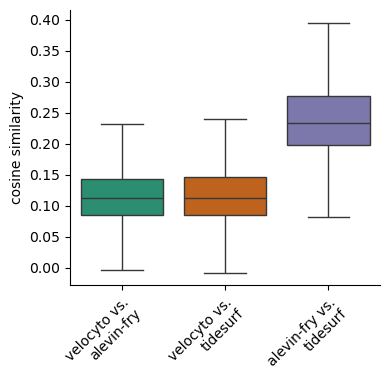

In [39]:
# Boxplots of cosine similarities of velocities
fig, ax = plt.subplots(figsize=(4, 4))

sns.boxplot(
    data=velocities_cosine,
    x="comparison",
    y="cosine_similarity",
    hue="comparison",
    palette="Dark2",
    showfliers=False,
    ax=ax
)
ax.set_xlabel("")
ax.set_xticks(
    ticks=ax.get_xticks(),
    labels=[
        lab.get_text().replace("_", " vs.\n")
        for lab in ax.get_xticklabels()
    ],
    rotation=45,
    ha="right",
    rotation_mode="anchor"
)
ax.set_ylabel("cosine similarity")

sns.despine(fig)
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR, "velocities_cosine.png"), dpi=200)

In [40]:
# Pearson correlation of velocities per gene
velocities_corr = pd.concat(
    [
        pd.DataFrame(
            data={
                "comparison": comp,
                "pearsonr": stats.pearsonr(
                    adata_1.layers["velocity"].toarray(),
                    adata_2.layers["velocity"].toarray(),
                    axis=0
                )[0]
            }
        )
        for comp, (adata_1, adata_2) in comp_dict_velocities.items()
    ]
).reset_index(drop=True)
velocities_corr.to_parquet(
    os.path.join(
        OUT_DIR, "velocities_corr.parquet.gz"
    ), compression="gzip"
)

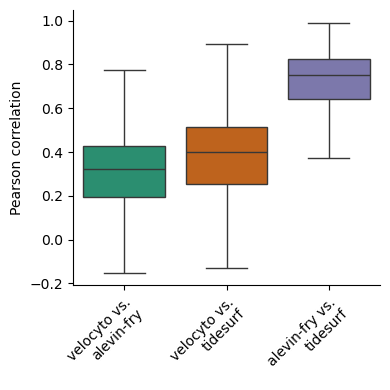

In [41]:
# Boxplots of pearson correlation of velocities
fig, ax = plt.subplots(figsize=(4, 4))

sns.boxplot(
    data=velocities_corr,
    x="comparison",
    y="pearsonr",
    hue="comparison",
    palette="Dark2",
    showfliers=False,
    ax=ax
)
ax.set_xlabel("")
ax.set_xticks(
    ticks=ax.get_xticks(),
    labels=[
        lab.get_text().replace("_", " vs.\n")
        for lab in ax.get_xticklabels()
    ],
    rotation=45,
    ha="right",
    rotation_mode="anchor"
)
ax.set_ylabel("Pearson correlation")

sns.despine(fig)
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR, "velocities_corr.png"), dpi=200)

In [42]:
# Compute pairwise common velocity genes (velocyto has much fewer genes!)
common_genes_velo = {
    method_1 + "_" + method_2: pd.Index(
        set(adatas_velocity[method_1][:, adatas_velocity[method_1].var["velocity_genes"]].var_names).union(
            set(adatas_velocity[method_2][:, adatas_velocity[method_2].var["velocity_genes"]].var_names)
        ).intersection(adatas_velocity[method_1].var_names).intersection(adatas_velocity[method_2].var_names)
    )
    for method_1, method_2 in combinations(adatas_velocity, 2)
}

for method, adata in adatas_velocity.items():
    print(f"{method}: {adata.var['velocity_genes'].sum()} velocity genes")

for comp, genes in common_genes_velo.items():
    print(f"{comp}: {len(genes)} common genes")

velocyto: 62 velocity genes
alevin-fry: 440 velocity genes
tidesurf: 530 velocity genes
velocyto_alevin-fry: 424 common genes
velocyto_tidesurf: 497 common genes
alevin-fry_tidesurf: 573 common genes


In [43]:
# Compute pairwise common highly variable genes (all genes for velocyto as it has fewer genes)
common_genes_hvg = {
    method_1 + "_" + method_2: pd.Index(
        set(adatas_velocity[method_1][:, adatas_velocity[method_1].var["highly_variable"]].var_names).union(
            set(adatas_velocity[method_2][:, adatas_velocity[method_2].var["highly_variable"]].var_names)
        ).intersection(adatas_velocity[method_1].var_names).intersection(adatas_velocity[method_2].var_names)
    )
    for method_1, method_2 in combinations(adatas_velocity, 2)
}

for method, adata in adatas_velocity.items():
    print(f"{method}: {adata.var['highly_variable'].sum()} highly variable genes")

for comp, genes in common_genes_hvg.items():
    print(f"{comp}: {len(genes)} common genes")

velocyto: 2000 highly variable genes
alevin-fry: 2000 highly variable genes
tidesurf: 2000 highly variable genes
velocyto_alevin-fry: 2883 common genes
velocyto_tidesurf: 2926 common genes
alevin-fry_tidesurf: 2432 common genes


In [44]:
# Create dictionaries for easier comparisons
comp_dict_velo = {
    method_1 + "_" + method_2: (
        adatas_velocity[method_1][:, common_genes_velo[method_1 + "_" + method_2]],
        adatas_velocity[method_2][:, common_genes_velo[method_1 + "_" + method_2]]
    )
    for method_1, method_2 in combinations(adatas_velocity, 2)
}

comp_dict_hvg = {
    method_1 + "_" + method_2: (
        adatas_velocity[method_1][:, common_genes_hvg[method_1 + "_" + method_2]],
        adatas_velocity[method_2][:, common_genes_hvg[method_1 + "_" + method_2]]
    )
    for method_1, method_2 in combinations(adatas_velocity, 2)
}

In [45]:
# Compare velocities: cosine similarities per cell
velocities_cosine_velo = pd.concat(
    [
        pd.DataFrame(
            data={
                "comparison": comp,
                "cosine_similarity": np.diagonal(
                    cosine_similarity(
                        adata_1.layers["velocity"].toarray(),
                        adata_2.layers["velocity"].toarray(),
                    )
                )
            }
        )
        for comp, (adata_1, adata_2) in comp_dict_velo.items()
    ]
).reset_index(drop=True)
velocities_cosine_velo.to_parquet(
    os.path.join(
        OUT_DIR, "velocities_velo_cosine.parquet.gz"
    ), compression="gzip"
)

In [46]:
# Compare velocities: cosine similarities per cell
velocities_cosine_hvgs = pd.concat(
    [
        pd.DataFrame(
            data={
                "comparison": comp,
                "cosine_similarity": np.diagonal(
                    cosine_similarity(
                        adata_1.layers["velocity"].toarray(),
                        adata_2.layers["velocity"].toarray(),
                    )
                )
            }
        )
        for comp, (adata_1, adata_2) in comp_dict_hvg.items()
    ]
).reset_index(drop=True)
velocities_cosine_hvgs.to_parquet(
    os.path.join(
        OUT_DIR, "velocities_hvg_cosine.parquet.gz"
    ), compression="gzip"
)

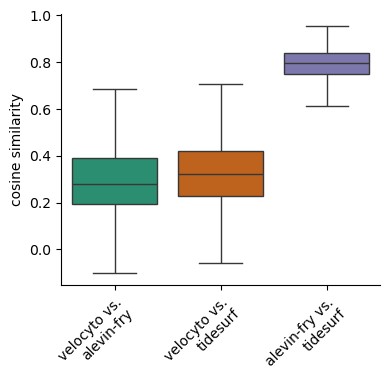

In [47]:
# Boxplots of cosine similarities of velocities: velocity genes
fig, ax = plt.subplots(figsize=(4, 4))

sns.boxplot(
    data=velocities_cosine_velo,
    x="comparison",
    y="cosine_similarity",
    hue="comparison",
    palette="Dark2",
    showfliers=False,
    ax=ax
)
ax.set_xlabel("")
ax.set_xticks(
    ticks=ax.get_xticks(),
    labels=[
        lab.get_text().replace("_", " vs.\n")
        for lab in ax.get_xticklabels()
    ],
    rotation=45,
    ha="right",
    rotation_mode="anchor"
)
ax.set_ylabel("cosine similarity")

sns.despine(fig)
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR, "velocities_velo_cosine.png"), dpi=200)

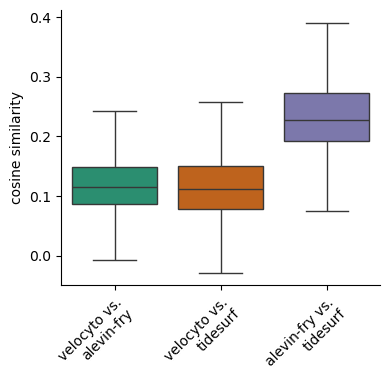

In [48]:
# Boxplots of cosine similarities of velocities: hvgs
fig, ax = plt.subplots(figsize=(4, 4))

sns.boxplot(
    data=velocities_cosine_hvgs,
    x="comparison",
    y="cosine_similarity",
    hue="comparison",
    palette="Dark2",
    showfliers=False,
    ax=ax
)
ax.set_xlabel("")
ax.set_xticks(
    ticks=ax.get_xticks(),
    labels=[
        lab.get_text().replace("_", " vs.\n")
        for lab in ax.get_xticklabels()
    ],
    rotation=45,
    ha="right",
    rotation_mode="anchor"
)
ax.set_ylabel("cosine similarity")

sns.despine(fig)
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR, "velocities_hvg_cosine.png"), dpi=200)

In [49]:
# Compare velocities: Pearson correlation per gene
velocities_corr_velo = pd.concat(
    [
        pd.DataFrame(
            data={
                "comparison": comp,
                "pearsonr": stats.pearsonr(
                    adata_1.layers["velocity"].toarray(),
                    adata_2.layers["velocity"].toarray(),
                    axis=0
                )[0]
            }
        )
        for comp, (adata_1, adata_2) in comp_dict_velo.items()
    ]
).reset_index(drop=True)
velocities_corr_velo.to_parquet(
    os.path.join(
        OUT_DIR, "velocities_velo_corr.parquet.gz"
    ), compression="gzip"
)

In [50]:
# Compare velocities: Pearson correlation per gene
velocities_corr_hvgs = pd.concat(
    [
        pd.DataFrame(
            data={
                "comparison": comp,
                "pearsonr": stats.pearsonr(
                    adata_1.layers["velocity"].toarray(),
                    adata_2.layers["velocity"].toarray(),
                    axis=0
                )[0]
            }
        )
        for comp, (adata_1, adata_2) in comp_dict_hvg.items()
    ]
).reset_index(drop=True)
velocities_corr_hvgs.to_parquet(
    os.path.join(
        OUT_DIR, "velocities_hvg_corr.parquet.gz"
    ), compression="gzip"
)

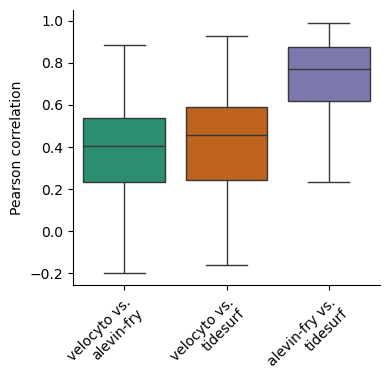

In [51]:
# Boxplots of Pearson correlation of velocities: velocity genes
fig, ax = plt.subplots(figsize=(4, 4))

sns.boxplot(
    data=velocities_corr_velo,
    x="comparison",
    y="pearsonr",
    hue="comparison",
    palette="Dark2",
    showfliers=False,
    ax=ax
)
ax.set_xlabel("")
ax.set_xticks(
    ticks=ax.get_xticks(),
    labels=[
        lab.get_text().replace("_", " vs.\n")
        for lab in ax.get_xticklabels()
    ],
    rotation=45,
    ha="right",
    rotation_mode="anchor"
)
ax.set_ylabel("Pearson correlation")

sns.despine(fig)
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR, "velocities_velo_corr.png"), dpi=200)

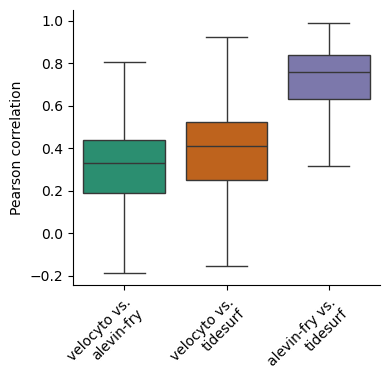

In [52]:
# Boxplots of Pearson correlation of velocities: hvgs
fig, ax = plt.subplots(figsize=(4, 4))

sns.boxplot(
    data=velocities_corr_hvgs,
    x="comparison",
    y="pearsonr",
    hue="comparison",
    palette="Dark2",
    showfliers=False,
    ax=ax
)
ax.set_xlabel("")
ax.set_xticks(
    ticks=ax.get_xticks(),
    labels=[
        lab.get_text().replace("_", " vs.\n")
        for lab in ax.get_xticklabels()
    ],
    rotation=45,
    ha="right",
    rotation_mode="anchor"
)
ax.set_ylabel("Pearson correlation")

sns.despine(fig)
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR, "velocities_hvg_corr.png"), dpi=200)

In [53]:
# Save processed AnnData objects
for method, adata in adatas_velocity.items():
    adata.write_h5ad(
        os.path.join(OUT_DIR, f"adata_{method}.h5ad"), compression="gzip"
    )